# **Demanda de Luz Argentina**
Este notebook muestra modelos de prediccion y decomposición de datos de series temporales. 

In [0]:
import pandas as pd
url = "https://raw.githubusercontent.com/DiploDatos/AnalisisSeriesTemporales/master/datasets/demanda.csv"
data = pd.read_csv(url)

In [2]:
import sys
IN_COLAB = 'google.colab' in sys.modules
DATA_FILE = 'datasets/nswretail.csv'
RAW_REPO = 'https://github.com/DiploDatos/AnalisisSeriesTemporales/raw/master/'
if IN_COLAB:
    DATA_FILE = RAW_REPO + DATA_FILE
    !wget -O get-x13as.sh {RAW_REPO + 'get-x13as.sh'}
    !sh get-x13as.sh
    !wget -O plotting.py {RAW_REPO + 'plotting.py'}

--2019-10-01 03:23:35--  https://github.com/DiploDatos/AnalisisSeriesTemporales/raw/master/get-x13as.sh
Resolving github.com (github.com)... 140.82.118.4
Connecting to github.com (github.com)|140.82.118.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/DiploDatos/AnalisisSeriesTemporales/master/get-x13as.sh [following]
--2019-10-01 03:23:35--  https://raw.githubusercontent.com/DiploDatos/AnalisisSeriesTemporales/master/get-x13as.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 236 [text/plain]
Saving to: ‘get-x13as.sh’

get-x13as.sh        100%[===================>]     236  --.-KB/s    in 0s      

2019-10-01 03:23:35 (45.8 MB/s) - ‘get-x13as.sh’ saved [236/236]

--2019-10-01 03:23:40--  https://

In [0]:
# Packages
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'
%matplotlib inline

plt.rcParams['figure.figsize'] = [15, 10]

#data=pd.read_csv('url', delimiter=",", parse_dates=True)
data.tail()

data.dtypes

dates=pd.to_datetime(data["TIPO"], format="%Y-%m-%d")

In [4]:
data["Fecha"] = dates
data = data.set_index("Fecha")
data.head()

y = data['Residencial'].copy()
y.index = y.index.to_period(freq='M')
ts = data['Residencial']

data.describe().round(2)


,Residencial,Comercial,Industrial/Comercial Grande,TOTAL
count,79.00,79.00,79.00,79.00
mean,4551935.29,3113096.42,3187977.02,10853008.74
std,654164.93,206829.98,124659.74,816874.81
min,3239380.70,2809183.13,2897618.67,9307334.16
25%,3990580.45,2948084.14,3109179.19,10223259.40
50%,4470715.12,3070853.24,3199317.20,10706955.32
75%,5092450.46,3270751.91,3275571.56,11476364.98
max,6193110.21,3606989.07,3460879.97,12607552.72


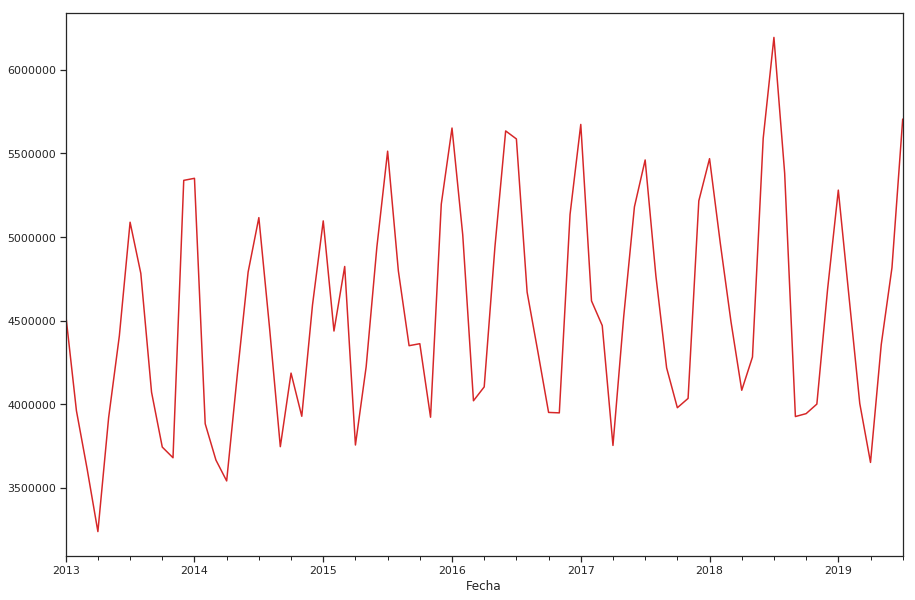

In [5]:
#calls
y.plot(color=red);#figsize=(9,6))

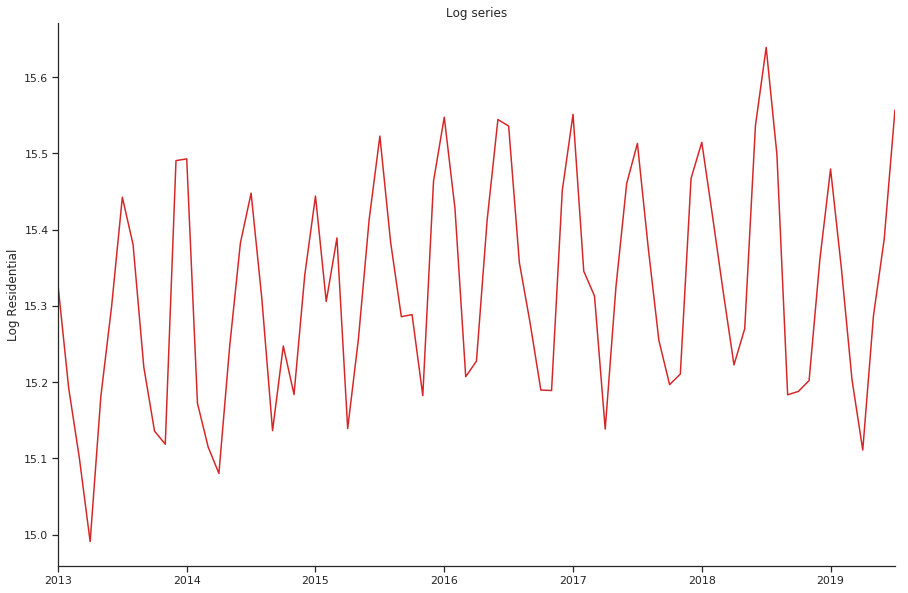

In [6]:
fig, ax= plt.subplots();#figsize=(9,6))
np.log(y).plot(color=red)
ax.set_xlabel('')
ax.set_ylabel('Log Residential')
ax.set_title('Log series')
ax.set_xticks([], minor=True)
sns.despine()
plt.show()

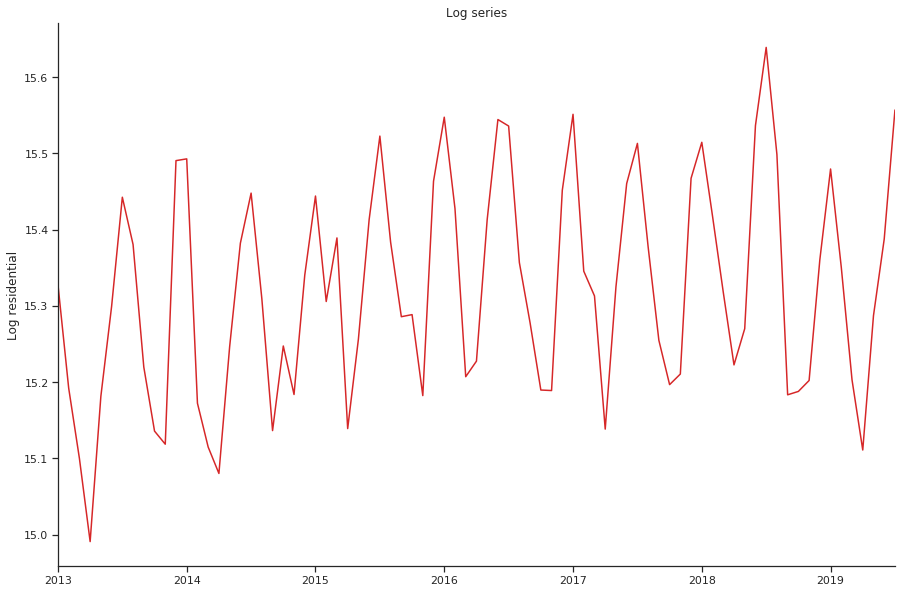

In [8]:


fig, ax= plt.subplots();#figsize=(9,6))
np.log(y).plot(color=red)
ax.set_xlabel('')
ax.set_ylabel('Log residential')
ax.set_title('Log series')
ax.set_xticks([], minor=True)
sns.despine()
plt.show()

# Analysis Exploratorio
### Decomposition:
Para hacer nuestro analysis avanzada primero necesitamos sacar cuatro componentes de nuestra data: observed, trend, seasonality and irregularity. The ```X13 ARIMA``` is an incredibly powerful tool for this.

In [9]:
decomposition = sm.tsa.x13_arima_analysis(ts,x12path='.')

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/x13.py:187: X13Warning: WARNING: At least one visually significant trading day peak has been
          found in one or more of the estimated spectra.
  warn(errors, X13Warning)


In [10]:
dir(decomposition)[-6:]

['observed', 'plot', 'results', 'seasadj', 'stdout', 'trend']

In [11]:
decomposition.seasadj.tail()

Fecha
2019-03-01    4.357587e+06
2019-04-01    4.448785e+06
2019-05-01    4.517256e+06
2019-06-01    4.351465e+06
2019-07-01    4.685038e+06
Name: seasadj, dtype: float64

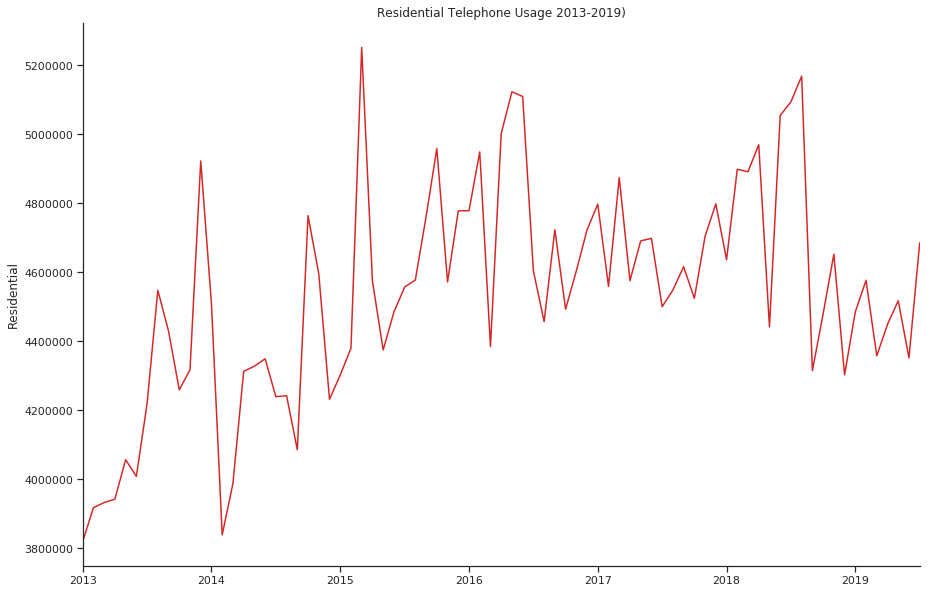

In [13]:
fig, ax= plt.subplots();#figsize=(9,6))
decomposition.seasadj.plot(color=red)
ax.set_xlabel('')
ax.set_ylabel('Residential')
ax.set_title('Residential Electricity Use 2013-2019)')
ax.set_xticks([], minor=True) # I prefer to remove the minor ticks for a cleaner plot
sns.despine()
plt.show()

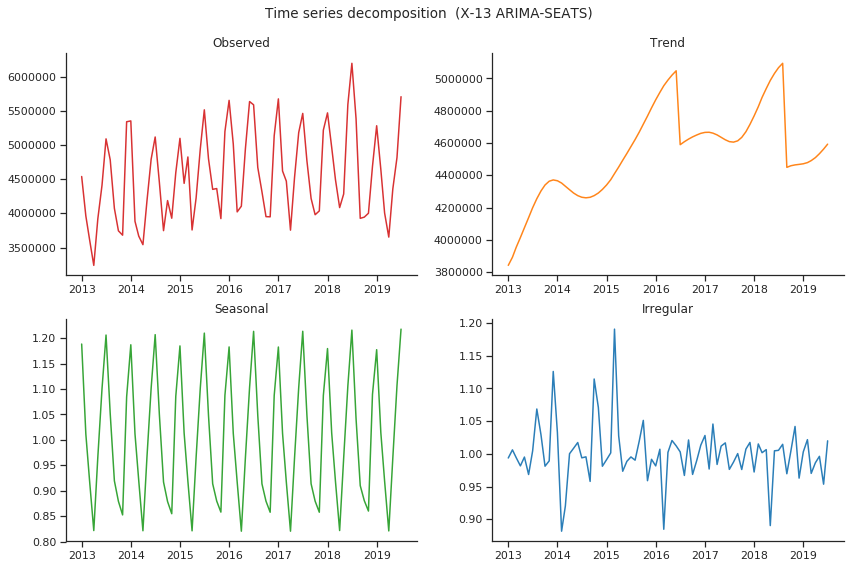

In [14]:
from plotting import plot_components_x13
plot_components_x13(decomposition)
plt.show()

In [0]:
f=open('x13results.txt', mode='w+')
f.write(decomposition.results)
f.close()

In [0]:
basic_decomposition = sm.tsa.seasonal_decompose(ts, model='multiplicative')

In [0]:
ts=decomposition.seasadj
ts.index=ts.index.to_period(freq='M')

Employing the information we extracted with ARIMA, we can use a variation of ***exponential smoothing*** designed for seasonality. 

In [18]:
model_sm = sm.tsa.Holt(ts).fit()
smoothed_sm = model_sm.fittedvalues
alpha_sm = model_sm.model.params['smoothing_level']
betha_sm = model_sm.model.params['smoothing_slope']
mse_sm = sm.tools.eval_measures.mse(ts,smoothed_sm)
print(' Smoothing parameter: alpha  {0:.3f}'.format(alpha_sm))
print(' Smoothing parameter: betha  {0:.3f}'.format(betha_sm))
print(' In-sample fit:')
print(' MSE               {0:.3f}'.format(mse_sm))

 Smoothing parameter: alpha  0.295
 Smoothing parameter: betha  0.042
 In-sample fit:
 MSE               68017641093.412


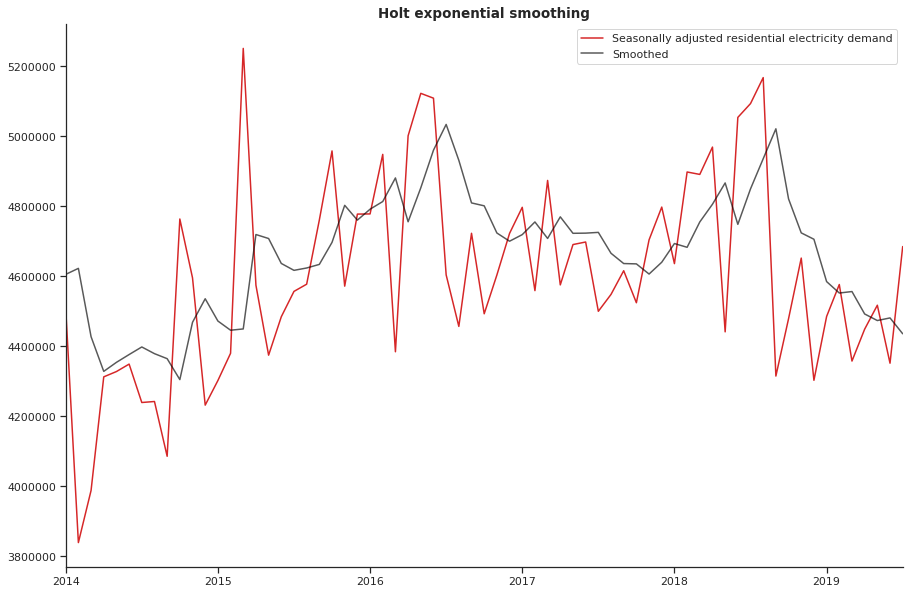

In [20]:
#smoothed=pd.Series(smoothed_sm, index=ts.index)

fig, ax= plt.subplots();#figsize=(9,6))

ts['2014':].plot(color='#D62728', label='Seasonally adjusted residential electricity demand')
smoothed_sm['2014':].plot(color='black', label='Smoothed', alpha=0.65)
plt.legend(loc='best')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_title(r'Holt exponential smoothing', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


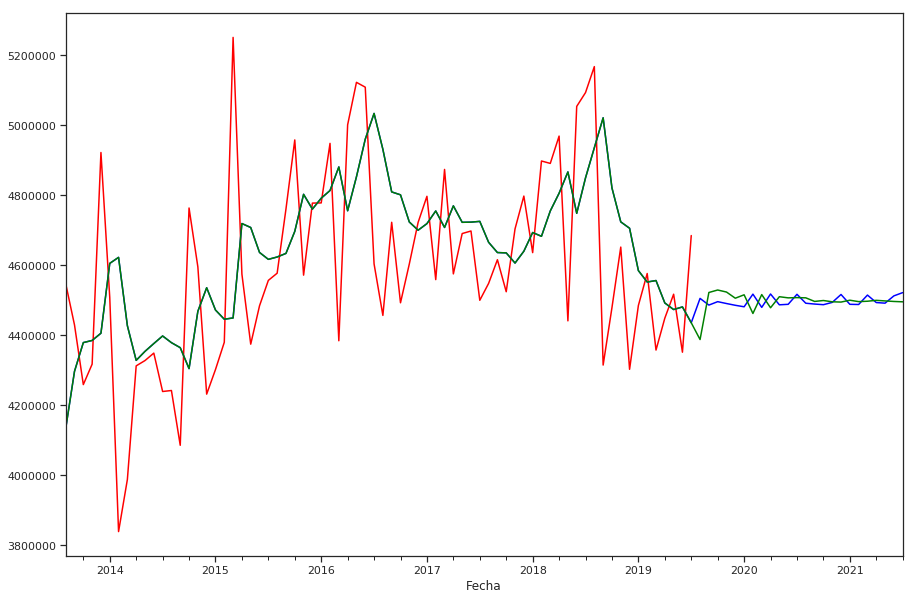

In [22]:
h=24
w=h*3
data = ts
model = sm.tsa.Holt
pred_index = data.index[-1] + np.array(range(1,h+1))
pred_rolling = pd.Series(0,index=pred_index)
pred_expanding = pd.Series(0,index=pred_index)
orig_fit = None
for i in range(0,h):
    current = pd.concat([data, pred_expanding.head(i)])
    expanding = model(current).fit()
    if i==0:
        orig_fit = expanding.fittedvalues
    rolling = model(current.tail(w)).fit()
    pred_expanding.update(expanding.forecast(1))
    pred_rolling.update(rolling.forecast(1))
ax = data[-w:].plot(color='red');#figsize=(9,6))
pd.concat([orig_fit[-w:],pred_expanding]).plot(ax=ax,color='blue');
pd.concat([orig_fit[-w:],pred_rolling]).plot(ax=ax,color='green');

Holt-winters exponential smoothing
We estimate several candidate specifications below. The AIC suggests a multiplicative model without damping for the original series, but we would need to make a likelihood adjustment or a validation set comparison to selected between this method and an additive model for a log transformation.

In [0]:
def hw_summary(model_sm):
    alpha_sm = model_sm.model.params['smoothing_level']
    betha_sm = model_sm.model.params['smoothing_slope']
    delta_sm = model_sm.model.params['smoothing_seasonal']
    mse_sm = sm.tools.eval_measures.mse(model_sm.data.endog,model_sm.fittedvalues)
    rmse_sm = sm.tools.eval_measures.rmse(model_sm.data.endog,model_sm.fittedvalues)
    print(' Smoothing parameter: alpha  {0:.3f}'.format(alpha_sm))
    print(' Smoothing parameter: betha  {0:.3f}'.format(betha_sm))
    print(' Smoothing parameter: delta  {0:.3f}'.format(delta_sm))
    print(' In-sample fit:')
    print(' MSE               {0:.3f}'.format(mse_sm))
    print(' RMSE               {0:.3f}'.format(rmse_sm))
    return rmse_sm

In [0]:
ahw_sm=sm.tsa.ExponentialSmoothing(y, trend='add', damped=False, 
                                   seasonal='add', seasonal_periods=12).fit()

In [25]:
hw_summary(ahw_sm);

 Smoothing parameter: alpha  0.101
 Smoothing parameter: betha  0.000
 Smoothing parameter: delta  0.449
 In-sample fit:
 MSE               105625499031.203
 RMSE               325000.768


In [26]:
mhw_sm=sm.tsa.ExponentialSmoothing(y, trend='add', damped=False, seasonal='mul', seasonal_periods=12).fit()
hw_summary(mhw_sm);

 Smoothing parameter: alpha  0.275
 Smoothing parameter: betha  0.000
 Smoothing parameter: delta  0.000
 In-sample fit:
 MSE               62379532130.429
 RMSE               249758.948


In [27]:
mhw_damped=sm.tsa.ExponentialSmoothing(y, trend='add', damped=True, seasonal='mul', seasonal_periods=12).fit()
hw_summary(mhw_damped);

 Smoothing parameter: alpha  0.292
 Smoothing parameter: betha  0.053
 Smoothing parameter: delta  0.000
 In-sample fit:
 MSE               62943192461.253
 RMSE               250884.819


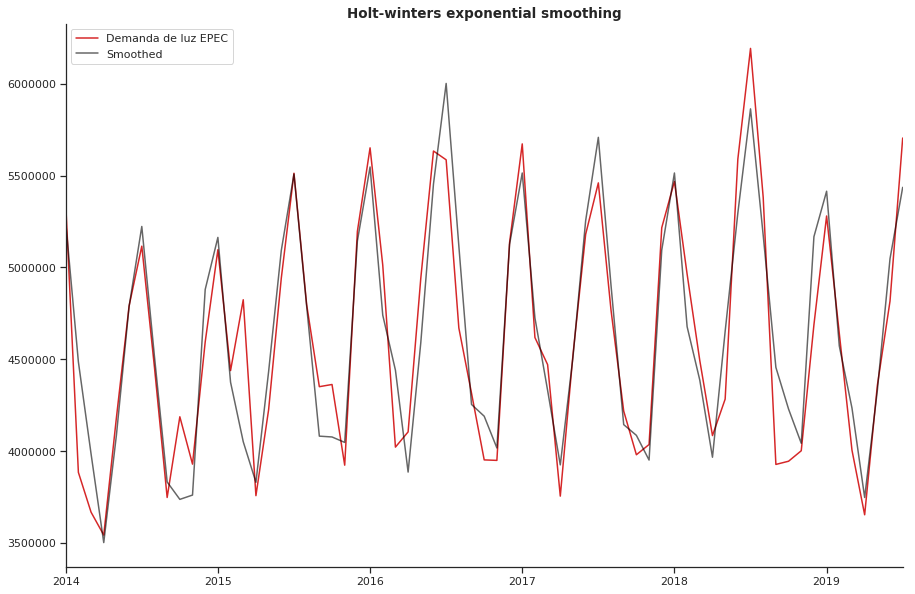

In [28]:
smoothed=pd.Series(mhw_sm.fittedvalues, index=y.index)

fig, ax= plt.subplots();#figsize=(9,6))

y['2014':].plot(color='#D62728', label='Demanda de luz EPEC')
smoothed['2014':].plot(color='black', label='Smoothed', alpha=0.6)
plt.legend(loc='best')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_title(r'Holt-winters exponential smoothing', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()

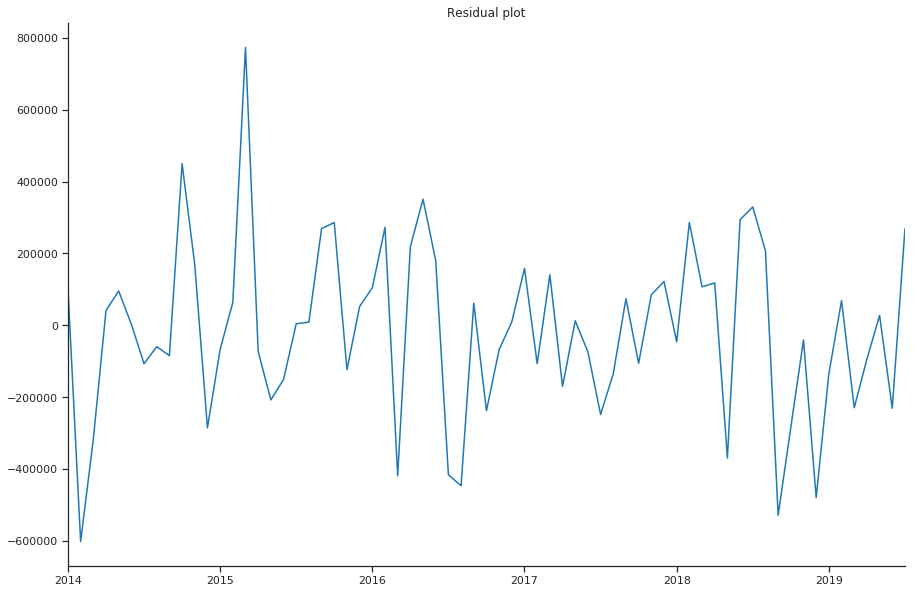

In [29]:
resid = (y-mhw_sm.fittedvalues)[12:] # we remove the first 12 observations as they are for initialisitation only

fig, ax= plt.subplots();#figsize=(9,6))
resid.plot(color=blue)
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot')
sns.despine()
plt.show()

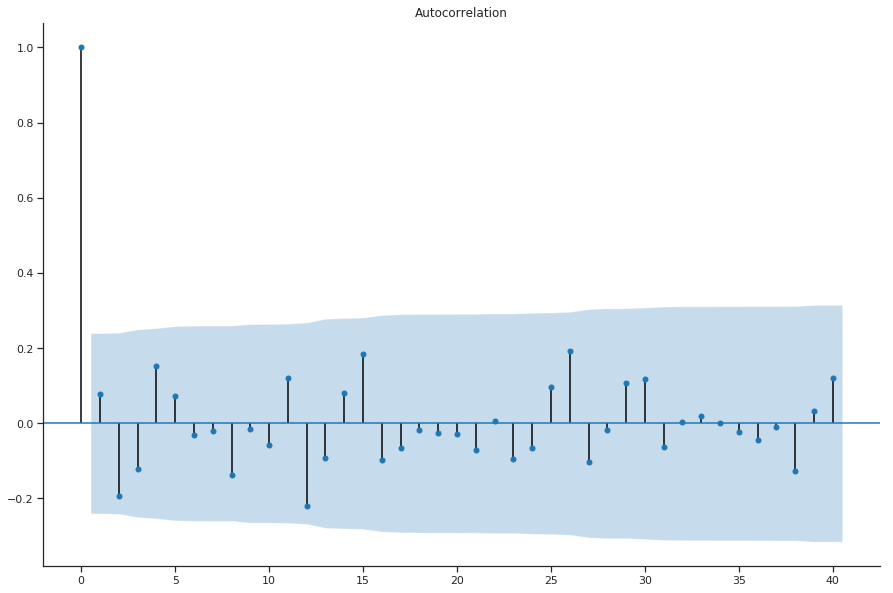

In [30]:
fig, ax = plt.subplots();#figsize=(9,6))
sm.graphics.tsa.plot_acf(resid, lags=40, ax=ax)
sns.despine()
plt.show()

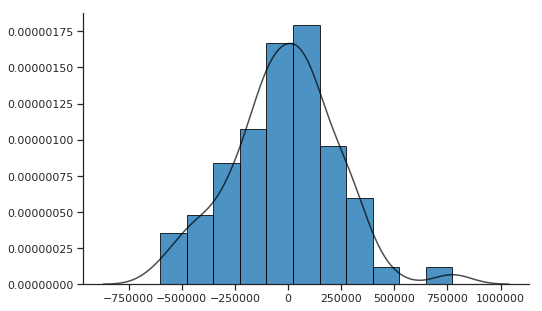

In [31]:
from plotting import histogram

histogram(resid)
plt.show()

# Model **Validation**

In [32]:
start_val = y.index[-round(len(y)/12*.2)*12]
start_val

Period('2018-08', 'M')

In [33]:
# Real time forecasting 

validation=y[start_val:].index
start = y.index.get_loc(start_val) 

pred1 = [] # seasonal random walk
pred2 = [] # additive holt winters
pred3 = [] # multiplicative holt winters
actual= []

for i in range(start, len(y)):
    
    actual.append(y.iloc[i]) # actual value
    
    pred1.append(y.iloc[i-12]) # seasonal random walk forecast
    
    model = sm.tsa.ExponentialSmoothing(y.iloc[:i], trend='add', damped=False, seasonal='add', seasonal_periods=12).fit()
    pred2.append(model.forecast(1)[0]) # additive holt winters forecast
    
    model = sm.tsa.ExponentialSmoothing(y.iloc[:i], trend='add', damped=False, seasonal='mul', seasonal_periods=12).fit()
    pred3.append(model.forecast(1)[0]) # multiplicate holt winters forecast
    

columns=['Seasonal RW', 'Additive', 'Multiplicative', 'Actual']
results = np.vstack([pred1,pred2,pred3,actual]).T
results = pd.DataFrame(results, columns=columns, index=validation)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [34]:
from scipy import stats

table = pd.DataFrame(0.0, index=results.columns[:-1], columns=['RMSE','SE'])
for i in range(len(results.columns)-1):
    table.iloc[i,0] = sm.tools.eval_measures.rmse(results.iloc[:,i], results.iloc[:,-1])
    table.iloc[i,1] = (results.iloc[:,i] - results.iloc[:,-1]).sem()
table.round(3)

,RMSE,SE
Seasonal RW,423173.552,104886.183
Additive,404951.835,100764.907
Multiplicative,377598.210,96441.200


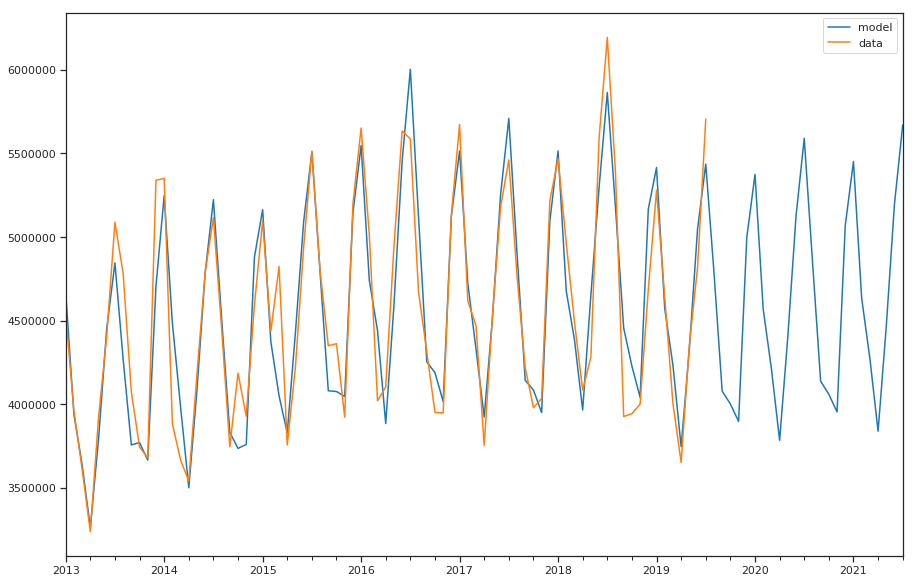

In [35]:
h=24

model = sm.tsa.ExponentialSmoothing(y, 
                    trend='add', damped=False, seasonal='mul', seasonal_periods=12).fit()

forecast = model.forecast(h)

plot = pd.DataFrame()
plot['model'] = pd.concat([model.fittedvalues, forecast])
plot['data'] = y
#pd.Series(model.fittedvalues + model.fcastvalues), 
#                         index=pd.period_range(y.index[0],y.index[-1]+h,freq=y.index.freq))

plot['2010':].plot();#figsize=(9,6))

## Conclusion:
As we can see, using the X13 ARIMA methods of decomposition and a more developed prediction method, Holt Exponential Smoothing, we were able to predict the time series with great accuracy. 